In [1]:
import pandas as pd
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
tests_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [3]:
all_features = pd.concat((train_data.iloc[:,1:-1], tests_data.iloc[:, 1:]))
numeric_features_index = (all_features.dtypes[all_features.dtypes != 'object']).index
# 对数化+标准化
all_features[numeric_features_index] = (all_features[numeric_features_index].apply(lambda x: np.log1p(x))).apply(lambda x: (x-x.mean()) / x.std())
all_labels = np.log1p(train_data['SalePrice'])
all_mean_labels = np.mean(all_labels)
all_std_labels = np.std(all_labels)
all_labels = all_labels.apply(lambda x: (x-all_mean_labels) / all_std_labels)
# 缺失值
all_features[numeric_features_index] = all_features[numeric_features_index].fillna(0)
# 离散值
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)

train_features = torch.tensor(all_features[:len(train_data)].values, dtype=torch.float32).to("cuda")
tests_features = torch.tensor(all_features[len(train_data):].values, dtype=torch.float32).to("cuda")

train_labels = (torch.tensor(all_labels, dtype=torch.float32).to("cuda"))
train_labels = train_labels.reshape(train_labels.shape[0], 1)

In [4]:
class Net(nn.Module):
    """Regression Model

    Args:
        nn (nn.Module): PyTorch Module
    """
    def __init__(self):
        """init net struct
        """
        super().__init__()
        self.dropout = nn.Dropout(0.001)
        self.outputs = nn.Linear(all_features.shape[1], 1)
    
    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """前向传播

        Args:
            features (torch.Tensor): features

        Returns:
            torch.Tensor: labels
        """
        return self.outputs(features)

In [5]:
def train(features: torch.Tensor, labels: torch.Tensor, num_epochs: int, lr: float, weight_decay: float, batch_size: int) -> np.array:
    """模型训练

    Args:
        features (torch.Tensor): features
        labels (torch.Tensor): labels
        num_epochs (int): 迭代次数
        lr (float): 学习率
        weight_decay (float): 暂退率
        batch_size (int): 批次大小

    Returns:
        torch.Tensor: 损失
    """
    net   = Net()
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss  = nn.MSELoss()
    
    is_training = net.training
    net.to("cuda")
    
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_training)
    
    train_losses = []
    
    tqdm_instance = tqdm(range(num_epochs), desc="训练中")
    for _ in tqdm_instance:
        # 训练模式
        net.train()
        train_loss = 0.0
        for X, y in data_loader:
            optim.zero_grad()
            l: torch.Tensor = loss(net(X), y)
            l.backward()
            optim.step()
            train_loss += l.item()
        train_losses.append(train_loss/num_epochs)
        tqdm_instance.set_postfix(loss=train_loss/num_epochs)
    return train_losses

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

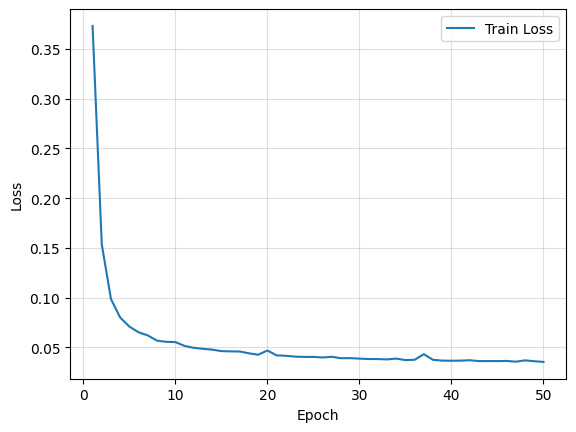

In [9]:
train_losses = train(features=train_features, labels=train_labels, num_epochs=50, lr=0.001, weight_decay=0.001, batch_size=60)

plt.plot(list(range(1, 50+1)), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.4)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# K折交叉验证+网格搜索 寻找最佳参数
from skorch import NeuralNetRegressor # 二分类任务、回归任务
from sklearn.model_selection import GridSearchCV, train_test_split

def k_fold() -> None:
    model = NeuralNetRegressor(
        module=Net(),
        criterion=nn.MSELoss(),
        optimizer=torch.optim.Adam,
        lr=0.001,
        max_epochs=100,
        device="cpu"
    )

    param_grid = {
        'batch_size': [30, 60, 90],
        'max_epochs': [50, 100, 150],
        'lr': [0.001, 0.01, 0.1]
    }

    # 创建GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,                  # estimator object（模型对象，由NeuralNetBinaryClassifier转换而来）
        param_grid=param_grid,            # dict或list of dicts，用于定义超参的搜索空间
        cv=5,                             # 交叉验证的折数或策略（默认为K折交叉验证）
        scoring='neg_mean_squared_error', # 定义模型评估指标
    )

    grid_search.fit(train_features.to("cpu"), train_labels.to("cpu"))

    print("最佳超参数：", grid_search.best_params_)
    print("最佳准确率：", grid_search.best_score_)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8022        0.5294  0.0425
      2        0.3019        0.2629  0.0388
      3        0.1863        0.2102  0.0388
      4        0.1574        0.1921  0.0500
      5        0.1412        0.1811  0.0575
      6        0.1295        0.1730  0.0434
      7        0.1205        0.1669  0.0555
      8        0.1133        0.1620  0.0446
      9        0.1075        0.1580  0.0416
     10        0.1027        0.1547  0.0420
     11        0.0986        0.1519  0.0437
     12        0.0951        0.1495  0.0465
     13        0.0921        0.1475  0.0467
     14        0.0895        0.1457  0.0430
     15        0.0872        0.1442  0.0430
     16        0.0851        0.1429  0.0405
     17        0.0833        0.1418  0.0426
     18        0.0817        0.1408  0.0487
     19        0.0803        0.1400  0.0437
     20        0.0790        0.1393  0.0427
     21        0.0778        0.1